In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../data/')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, get_hard_label
from transformer import BertEncoder
from loss import LBPloss
from visualize import visualize
from config import *

from tqdm import tqdm


In [2]:
df = pd.read_csv('../../data/df.csv')
print(df.shape)
df.head()

(1646, 11)


,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type
0,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1349, 420, 100, 113]",1349,420,100,113,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
1,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1575, 720, 163, 213]",1575,720,163,213,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
2,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1559, 411, 226, 168]",1559,411,226,168,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
3,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[427, 585, 160, 160]",427,585,160,160,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
4,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[535, 7, 137, 116]",535,7,137,116,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...


In [3]:

df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('file_name')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    
    data  = df_data.get_group(img_id)
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
    return dict(image_id = img_id, boxes = boxes)

train_list = [get_data(img_id) for img_id in df.file_name.unique()]
print(len(train_list))
train_list[0]

1265


{'image_id': 'patch_images/2021.01.06/LBC37-20210102(1)/LBC37-20210102(1)_1016.png',
 'boxes': array([[1349.,  420.,  100.,  113.,    0.]])}

In [4]:
len(df.file_name.unique())

1265

In [5]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]


test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [6]:
config = ModelConfig()

In [53]:
# BATCH_SIZE = 8
# STRIDE = 96
# KERNEL_SIZE = 128
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
    stride=config.stride,
    kernel_size=config.kernel_size
)
train_loader = DataLoader(
    dataset=train_dataset,
#     batch_size=BATCH_SIZE,
    batch_size=32,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
    stride=config.stride,
    kernel_size=config.kernel_size
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [8]:
images, cell_iou, targets, path = next(iter(train_loader))
print(images.shape)
print(cell_iou.shape)
print(targets.shape)
# print(boxes)
# boxes = np.array(boxes)
# boxes[:,2] = boxes[:,2] + boxes[:,0]
# boxes[:,3] = boxes[:,1] + boxes[:,3]
# visualize(image.squeeze().numpy(), boxes[:,:4])

torch.Size([8, 1568, 1568, 3])
torch.Size([8, 256, 1])
torch.Size([8, 256, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1568, 1568, 3)


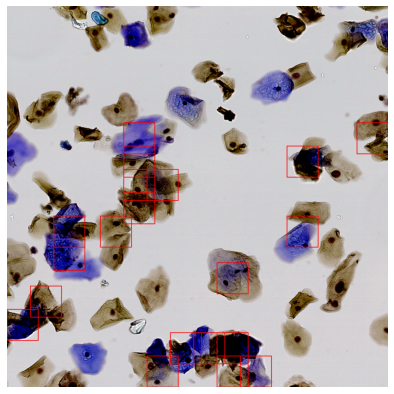

In [9]:
IMAGE_NUM=1
kernel_size = config.kernel_size
stride = config.stride
grid_size = 1 + int((images.shape[1]- kernel_size) / stride )
# row, col = (cell_iou.view(8,64,64)[IMAGE_NUM] > 0.6).nonzero(as_tuple=True)
row, col = torch.where(cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] > 0.7)
# row, col = torch.where(cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] < 0.1)
# row, col = torch.where((cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]>0.1)&(cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]<0.8))
bboxes = []

for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM].numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1568, 1568, 3)


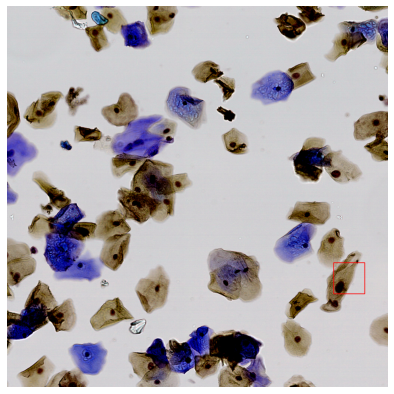

In [10]:
# IMAGE_NUM=1
# row, col = (cell_iou.view(8,64,64)[IMAGE_NUM] > 0.6).nonzero(as_tuple=True)
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] > 0.7)
# row, col = torch.where((targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]<0.5)&(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]>0.))
bboxes = []

kernel_size = config.kernel_size
stride = config.stride
for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUMpath].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM].numpy(), bboxes)

<class 'numpy.ndarray'>
[[1359.  155.  224.  182.    0.]]
(2048, 2048, 3)


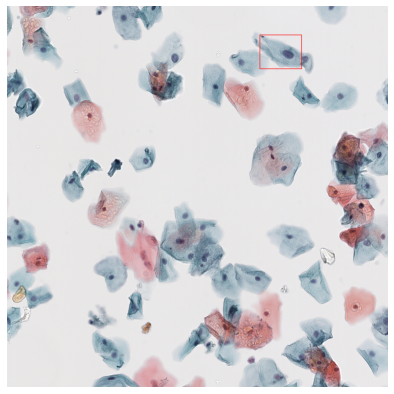

In [11]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])

In [12]:
# config.embeding_size

In [13]:
device = torch.device('cuda')
# model = CNNModel().to(device)
model = BertEncoder(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00002, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [14]:
# saved_model = '../trained_models/model_v1.pt'
# model.load_state_dict(torch.load(saved_model))

In [15]:
epochs = 10
init_loss = 2.
saved_model = '../trained_models/model_v1.pt'

for epoch in (range(epochs)) :
    batch_losses = []
    loop = tqdm(train_loader, leave=True)
    model.train()
    for images, iou, targets, path in loop :

        batch_size, grid_len, _ = iou.shape
        images = images.permute(0,3,1,2).to(device)

#         indices, iou, targets = get_indices(iou, targets)
        labels = get_hard_label(iou, targets)
        
#         labels = torch.cat([iou, targets], dim=-1)
        labels = labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss, ce_loss, num_ab = loss_fn(outputs, labels)

        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1./(epochs+1))
        scaler.step(optimizer)
        scaler.update()
        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
        batch_losses.append(loss.item())
        mean_loss = sum(batch_losses) / len(batch_losses)
        loop.set_postfix(total_loss=mean_loss, ce_loss=ce_loss.item(), num_ab=num_ab.item()) 
        
    if mean_loss < init_loss :
        init_loss = mean_loss
        torch.save(model.state_dict(), saved_model)
        print('model is saved')        


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


  0%|          | 0/158 [00:00<?, ?it/s]

model is saved


100%|██████████| 158/158 [00:38<00:00,  4.10it/s, ce_loss=276, num_ab=15, total_loss=0.0502]


In [16]:
images, cell_iou, targets, path = next(iter(train_loader))
images = images.permute(0,3,1,2).to(device)
outputs = model(images)
print(images.shape)
outputs.shape

torch.Size([8, 3, 1568, 1568])


torch.Size([8, 256, 3])

In [17]:
# outputs[:4,:10,:]

In [18]:
(outputs[0,:,:] == outputs[2,:,:]).sum()

tensor(0, device='cuda:0')

### 

In [19]:
saved_model = '../trained_models/model_v2.pt'
torch.save(model.state_dict(), saved_model)
# saved_model = '../trained_models/model_v1.pt'



In [20]:
saved_model = '../trained_models/model_v1.pt'
device = torch.device('cuda')
model = BertEncoder(config).to(device)
model.load_state_dict(torch.load(saved_model))
model.eval()

BertEncoder(
  (layer): ModuleList(
    (0): BertLayer(
      (mlp): FeedForwardBlock(
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (mha): MultiHeadAttention(
        (keys): Linear(in_features=768, out_features=36, bias=True)
        (queries): Linear(in_features=768, out_features=36, bias=True)
        (values): Linear(in_features=768, out_features=768, bias=True)
        (att_drop): Dropout(p=0, inplace=False)
        (projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (layernorm_mlp): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layernorm_mha): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout_mlp): Dropout(p=0.0, inplace=False)
      (dropout_mha): Dropout(p=0.0, inplace=False)
    )
    (1): BertLayer(
      (

In [54]:

images, cell_iou, targets , path = next(iter(train_loader))
# images, cell_iou, targets , path = next(iter(test_loader))
print(images.shape)
# print(cell_iou.shape)
batch_size, seq_len, _ = cell_iou.shape
# indices = torch.arange(start=0,end=seq_len,step=1)
images = images.permute(0,3,1,2).to(device)
# image = image.to(device)
with torch.no_grad():
    outputs = model(images)
print(outputs.shape)

torch.Size([32, 1568, 1568, 3])
torch.Size([32, 256, 3])


In [22]:
kernel_size = config.kernel_size
stride = config.stride
grid_size = 1 + int((images.shape[2]- kernel_size) / stride )
print(grid_size)

NUM_Class = 3


16


In [23]:
IMAGE_NUM=4
results = torch.argmax(torch.nn.Softmax(dim=-1)(outputs[IMAGE_NUM,:,:]).view(grid_size,grid_size,-1), dim=-1)
results

tensor([[2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0],
        [0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 1, 0, 0],
        [0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 2],
        [0, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 1, 2],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 1],
        [0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1],
        [0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 2],
        [1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 1],
        [0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1],
        [0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2],
        [0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1],
        [1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 1],
        [1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


81
(1568, 1568, 3)


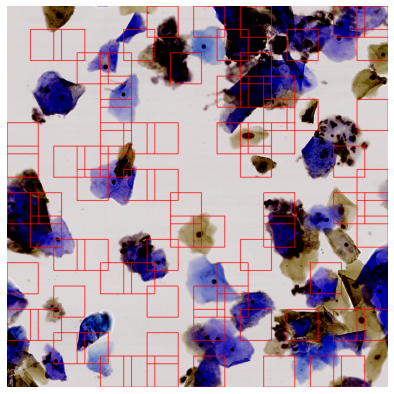

In [46]:
# image with prediction
IMAGE_NUM=0

# abnormal cell
results = torch.argmax(torch.nn.Softmax(dim=-1)(outputs[IMAGE_NUM,:,:]).view(grid_size,grid_size,-1), dim=-1)
row, col = torch.where(torch.eq(results, 1.))

bboxes = []

# for x, y in zip(col, row) :
for x, y in zip(row, col) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))

visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)

patch_images/2021.01.11/LBC199-20210106(1)/LBC199-20210106(1)_1192.png
(2048, 2048, 3)


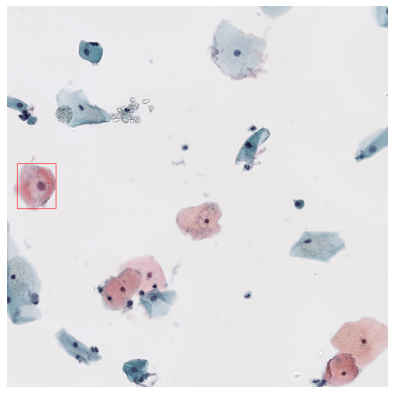

In [65]:
# image with annotation
IMAGE_NUM=11
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'
train_image = cv2.imread(abs_path + img_path)
print(img_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])